In [5]:
# add path:
data_path = '../DRIVE_dataset/datasets/'

# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print("Congrats! You selected the correct folder :)")
    for i in os.listdir(data_path):
        print(i)
        
        
# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.transforms import Transform
from dataset import *
import warnings
warnings.filterwarnings("ignore")

Congrats! You selected the correct folder :)
test
training


## Create Dataset and plot first image

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 32.78it/s]


Number of samples in the training dataset: 20


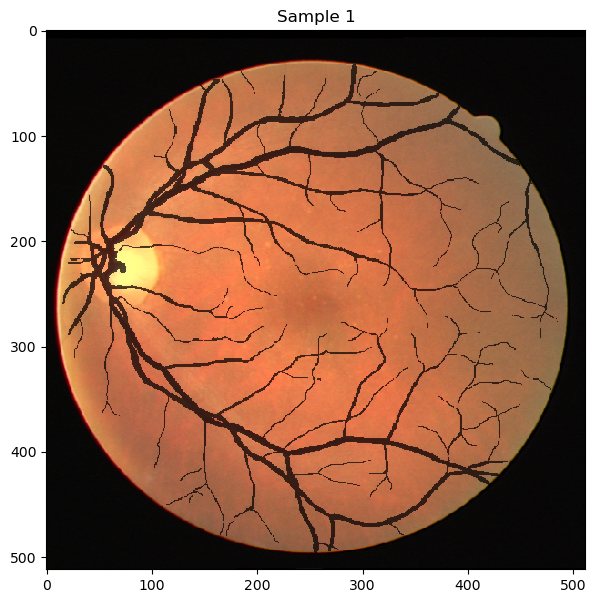

In [10]:
train_dict_list = build_dict_vessels(data_path, mode='training')
#test_dict_list = build_dict_vessels(data_path, mode='test')

train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadVesselData())
#test_dataset = monai.data.CacheDataset(test_dict_list, transform=LoadVesselData())

print(f'Number of samples in the training dataset: {len(train_dict_list)}')

for i in range(1):
    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")

In [11]:
# Create the composed transform
composed_transform_new = monai.transforms.Compose([
    LoadVesselData(),
    monai.transforms.AddChanneld(keys=['img', 'mask']),
    monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
    #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
    monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest']),
    monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[256,256], random_size=False)
])

train_dataset_new = monai.data.CacheDataset(train_dict_list, transform=composed_transform_new)
print(len(train_dataset_new.data))

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 28.35it/s]

20


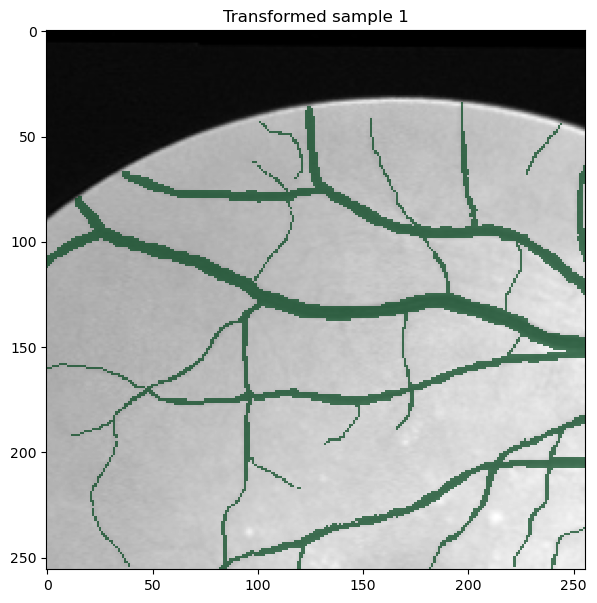

In [26]:
# Visualize the transformed dataset
for i in range(1):
    visualize_vessel_sample(train_dataset_new[i], title=f"Transformed sample {i+1}")

In [27]:
# Dataloader
train_dataloader = monai.data.DataLoader(train_dataset_new, batch_size=5, shuffle=True)

In [28]:
# Setting up the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters

loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The used device is cuda


In [48]:
# Setting up the training loop
def from_compose_to_list(transform):
    return transform.transforms

from tqdm import tqdm
import wandb

run = wandb.init(
    project='DRIVE',
    name='03-03-25',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'transform': from_compose_to_list(composed_transform_new),
        'batch_size': train_dataloader.batch_size,
        'layers': 5,
        'parameters': n,
        'dice': 0,
        'HausdorffDistance': 0,       
    }
)

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'vessels'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

#def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
def log_to_wandb(epoch, train_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    #wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'results': log_imgs})
    
for epoch in tqdm(range(200)):
    
    # training
    model.train()    
    epoch_loss = 0
    step = 0
    for batch_data in train_dataloader: 
        step += 1
        optimizer.zero_grad()
        outputs = model(batch_data["img"].float().to(device))
        loss = loss_function(outputs, batch_data["mask"].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss/step
    
    """# validation
    step = 0
    val_loss = 0
    for batch_data in validation_loader:
        step += 1
        model.eval()
        outputs = model(batch_data['img'].float().to(device))
        loss = loss_function(outputs, batch_data['mask'].to(device))
        val_loss+= loss.item()
    val_loss = val_loss / step
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)"""
    log_to_wandb(epoch, train_loss, batch_data, outputs)
    
# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,▅▆▄▄▇▄▅▃▅▄▄▄▅▅▆▅▂▃▃▆▁▄▆▃█▁▅▄▆▅▂▂▅▂▂▄▃▆▃▅
epoch,199
train_loss,0.20789


In [49]:
# Evaluate the trained network
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the X-ray image, the ground truth (green)
    and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256])
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu())).squeeze()
    
    fig, ax = plt.subplots(1,3, figsize = [12, 10])
    # Plot X-ray image
    ax[0].imshow(sample["img"].squeeze(), 'gray')    
    ax[1].imshow(sample["img"].squeeze(), 'gray')
    # Plot ground truth
    mask = np.squeeze(sample['mask'])
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    ax[1].imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[1].set_title('Ground truth')
    # Plot output
    overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
    ax[2].imshow(sample['img'].squeeze(), 'gray')
    ax[2].imshow(overlay_output, 'Reds', alpha = 0.7, clim=[0,1])
    ax[2].set_title('Prediction')
    plt.show()

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 40.05it/s]


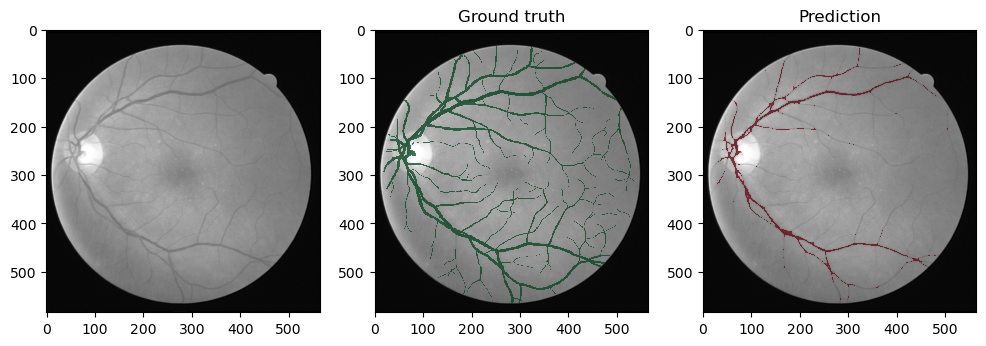

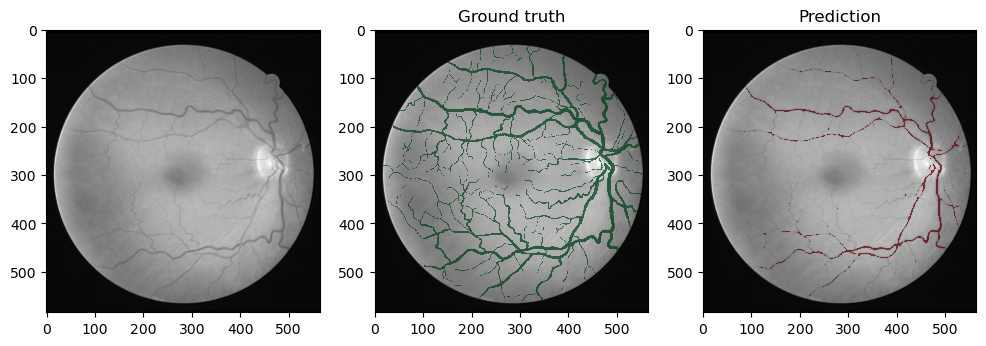

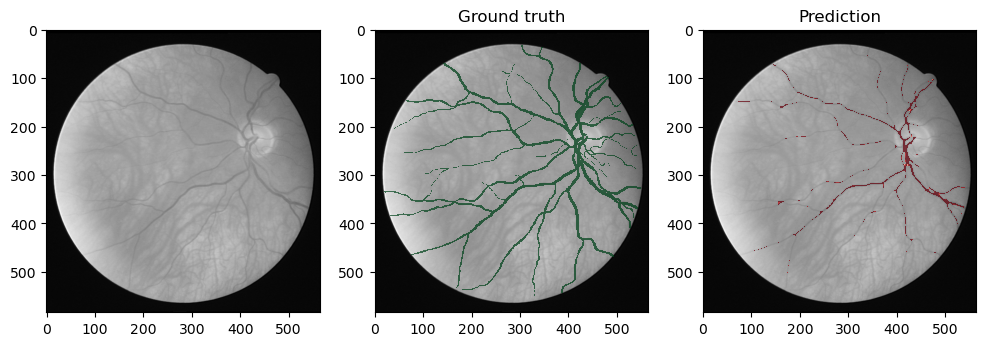

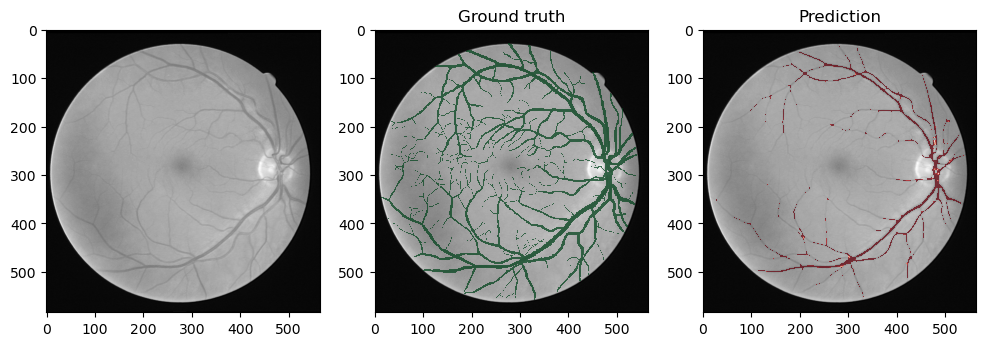

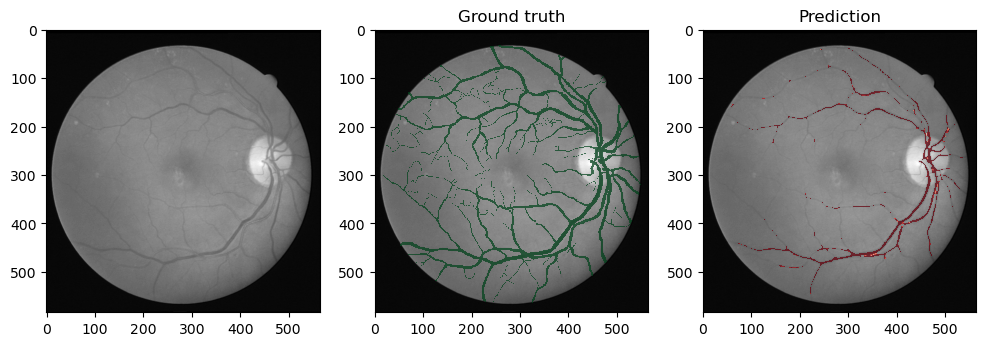

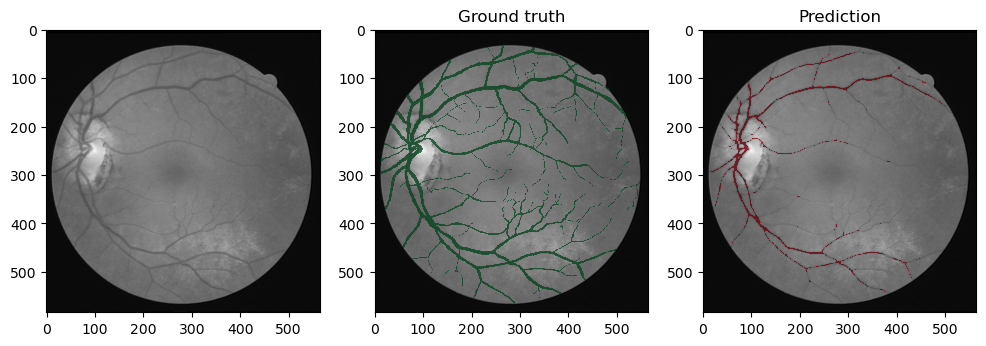

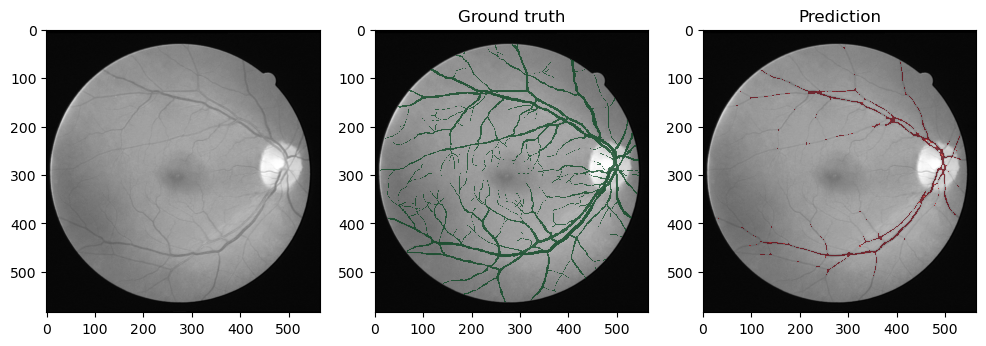

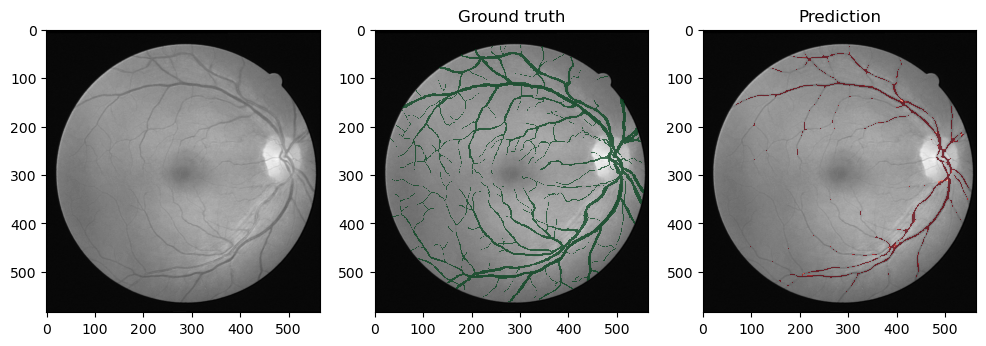

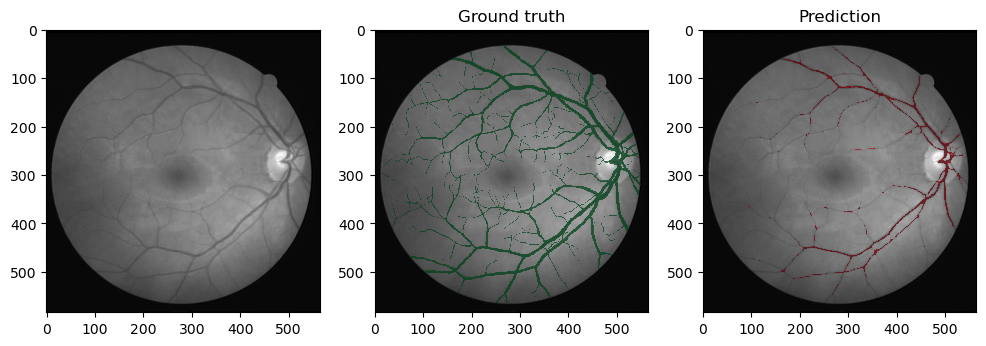

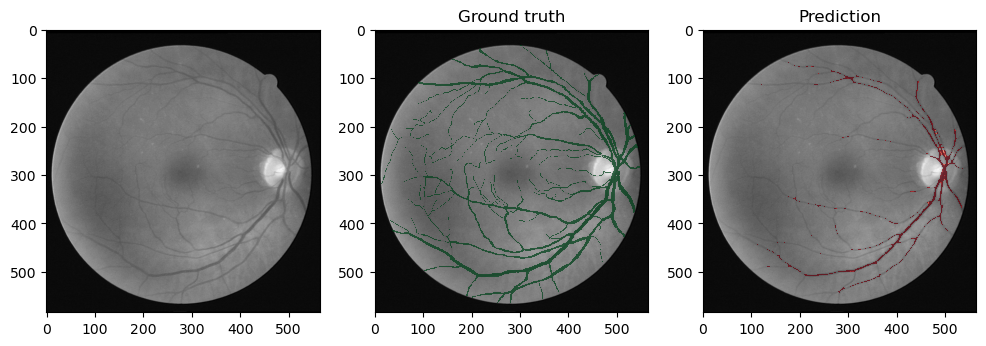

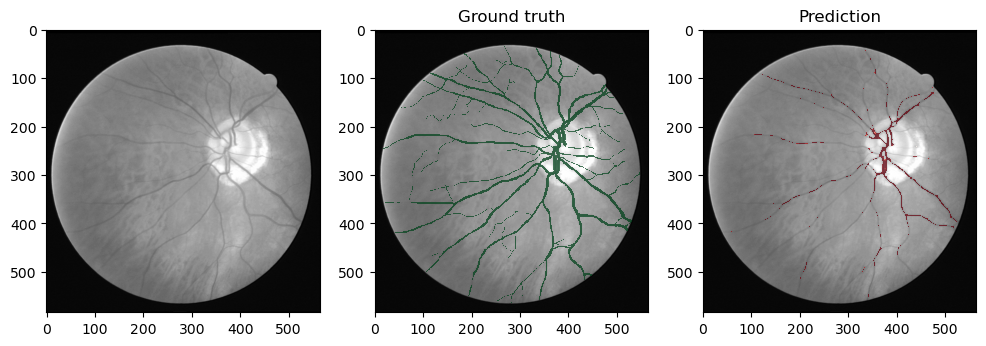

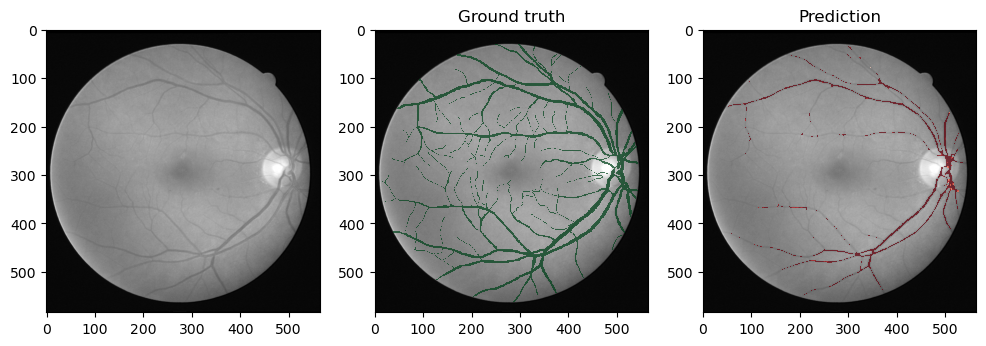

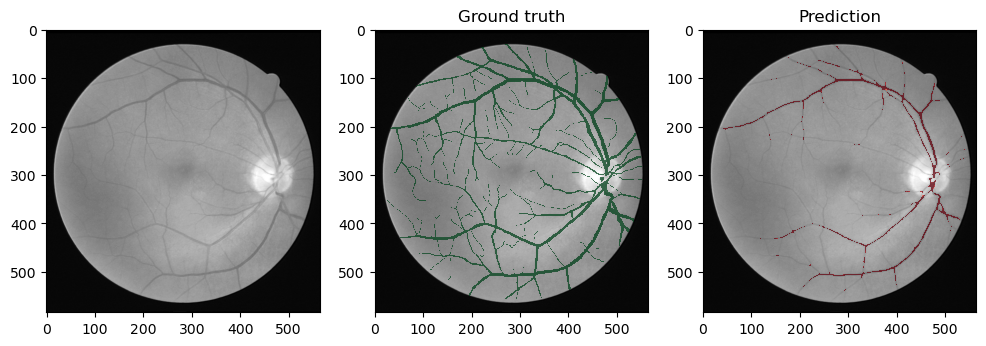

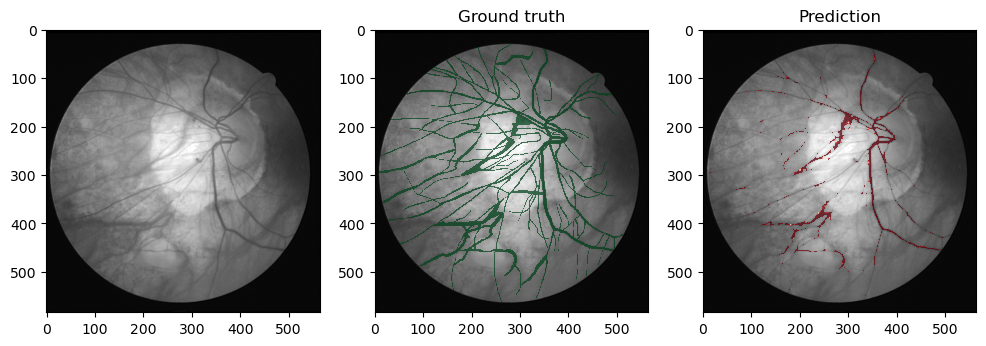

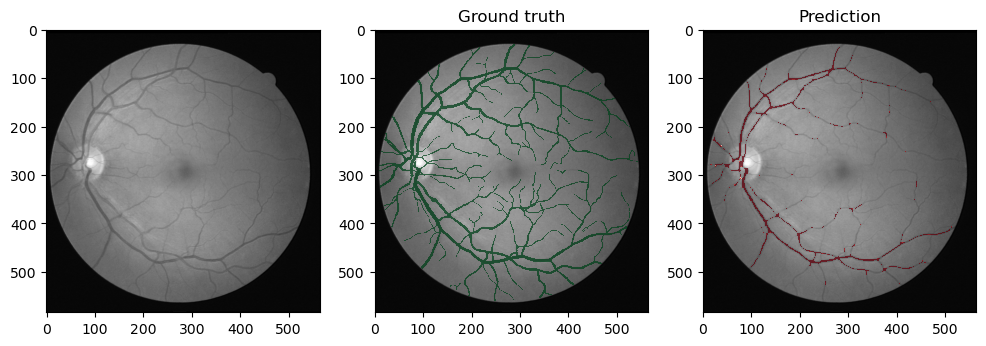

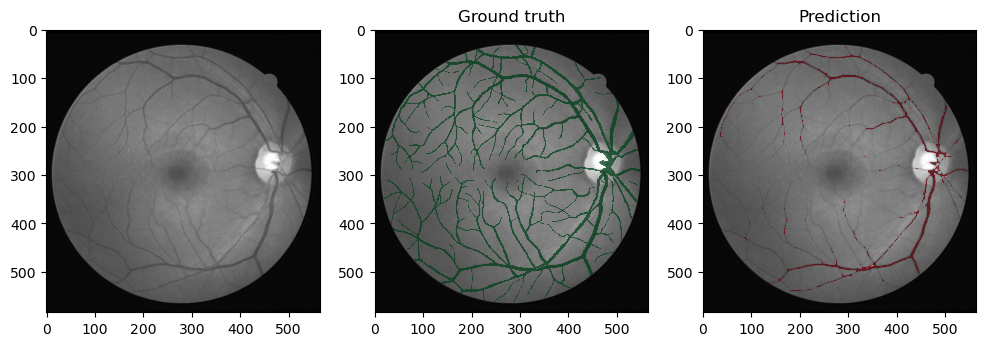

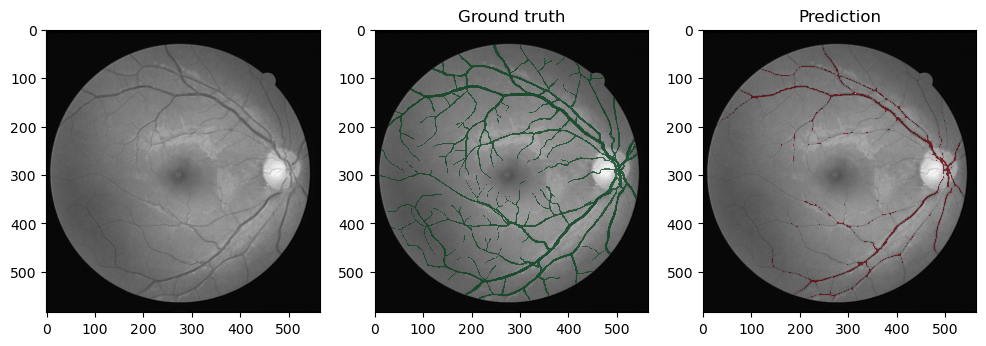

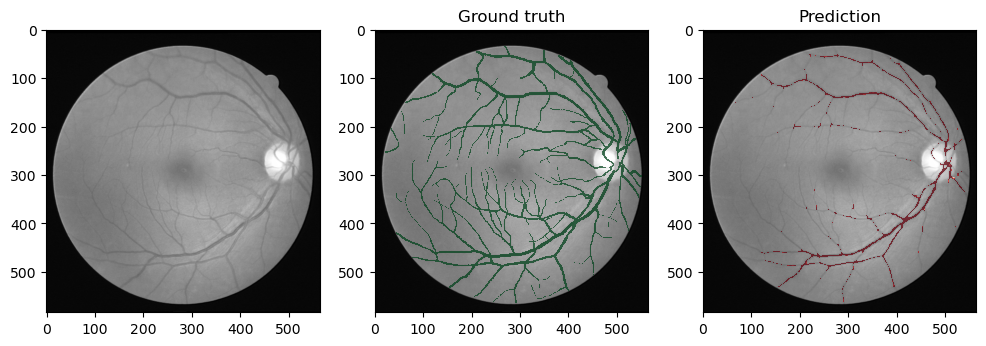

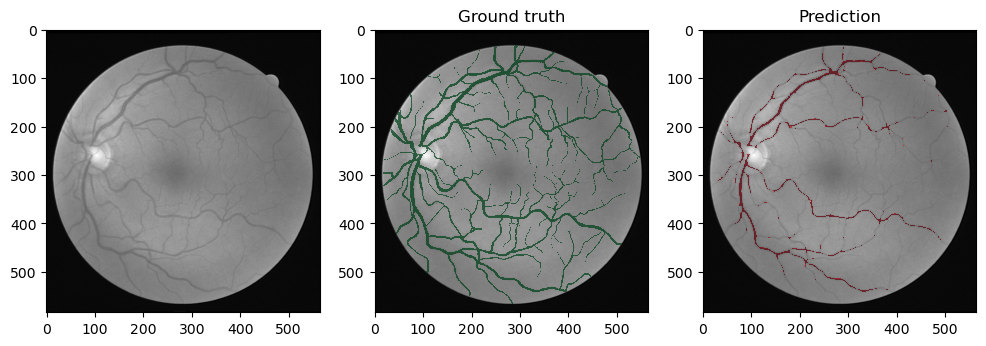

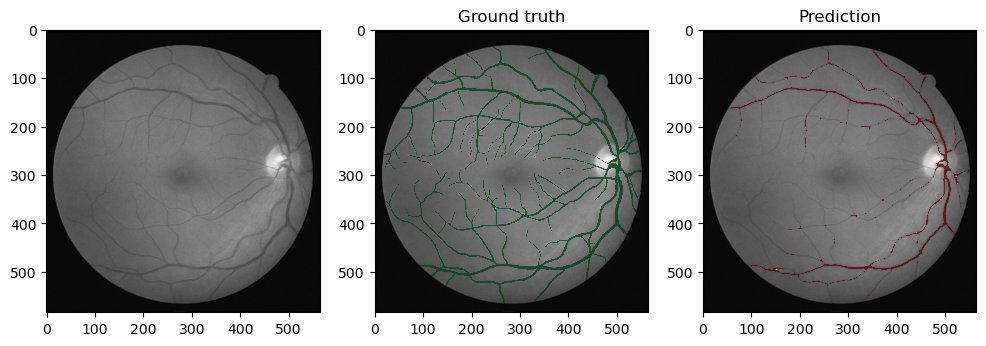

In [50]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
        LoadVesselData(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ]
)
test_dataset = monai.data.CacheDataset(train_dict_list, transform=test_transform)
test_dataloader = monai.data.DataLoader(test_dataset, batch_size=1)

for sample in test_dataloader:
    visual_evaluation(sample, model)

In [51]:
# Compute evaluation metrics
def compute_metric(dataloader, model, metric_fn):
    """
    This function computes the average value of a metric for a data set.
    
    Args:
        dataloader (monai.data.DataLoader): dataloader wrapping the dataset to evaluate.
        model (torch.nn.Module): trained model to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        (float) the mean value of the metric
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256])
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    Sigmoid = torch.nn.Sigmoid()
    
    mean_value = 0
    
    for sample in dataloader:
        with torch.no_grad():
            output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu()))
        mean_value += metric_fn(output, sample["mask"])
    
    return (mean_value / len(dataloader)).item()

In [52]:
api = wandb.Api()
run = api.run(f"DRIVE/{run_id}")

In [53]:
# Dice
metric_fn = monai.metrics.DiceMetric()
dice = compute_metric(test_dataloader, model, metric_fn)
run.summary["dice"] = dice
run.summary.update()
print(f"Dice on test set: {dice:.3f}")

Dice on test set: 0.811


In [54]:
# Hausdorff distance
metric_fn = monai.metrics.HausdorffDistanceMetric()
HausdorffDistance = compute_metric(test_dataloader, model, metric_fn)
run.summary["HausdorffDistance"] = HausdorffDistance
run.summary.update()
print(f"HausdorffDistance on test set: {HausdorffDistance:.3f}")

HausdorffDistance on test set: 55.091
